# Deep learning - CNN 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2024-04-09 12:50:38.536253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
    
lr_scheduler = LearningRateScheduler(scheduler)

def train_model(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    if use_scheduler == True:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])
    else:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    return history

In [7]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

In [8]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

In [9]:
def plot_evaluation(model_list, mae):
    
    fig, ax = plt.subplots()
    
    ax.bar(model_list, mae, width=0.3)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.set_ylim(0, max(mae)+0.15)
    for index, value in enumerate(mae):
        ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
    
    plt.tight_layout()

In [10]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [11]:
# Create a single-step window for a kernel length of 6
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 1
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH - 1

train_ds_ss = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
val_ds_ss = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
test_ds_ss = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

In [12]:
# Create a CNN model
ss_cnn = Sequential([
    Conv1D(filters=32, kernel_size=KERNEL_LENGTH, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ss_cnn_history = train_model(ss_cnn, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0406 - mean_absolute_error: 0.1195 - val_loss: 0.0027 - val_mean_absolute_error: 0.0405 - learning_rate: 0.0010
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0654 - val_loss: 0.0082 - val_mean_absolute_error: 0.0669 - learning_rate: 0.0010
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0616 - val_loss: 0.0048 - val_mean_absolute_error: 0.0550 - learning_rate: 9.0484e-04
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0607 - val_loss: 0.0034 - val_mean_absolute_error: 0.0466 - learning_rate: 8.1873e-04
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0596 - val_loss: 0.0027 - val_mean_absolute_error: 0.0428 - learning_rate: 7.4082e-04
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - mean_absolute_error: 0.0554 - val_loss: 0.0023 - 

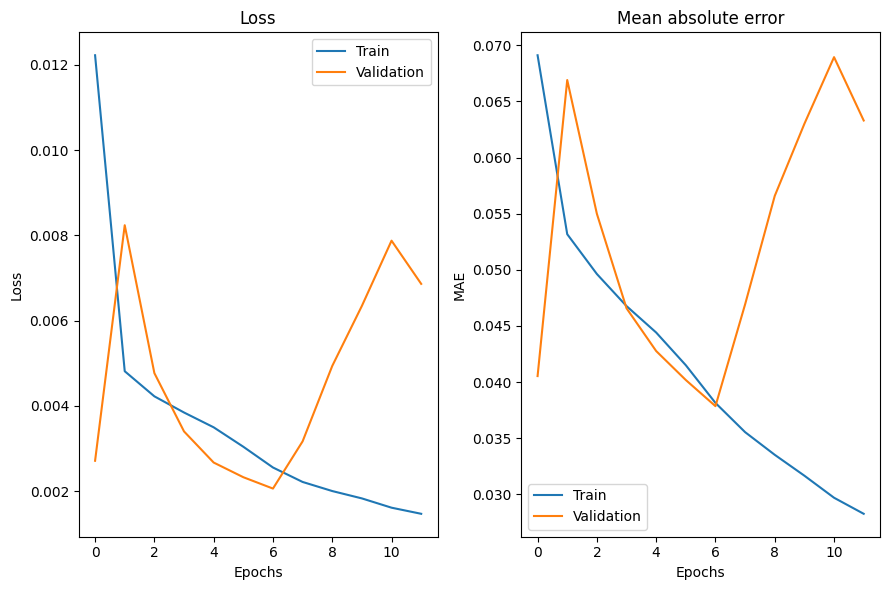

In [13]:
plot_history(ss_cnn_history)

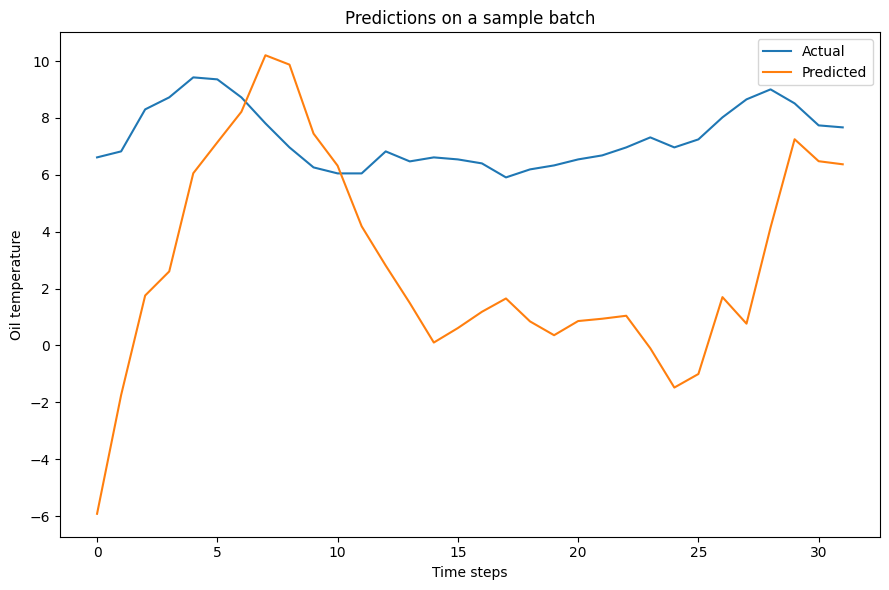

In [14]:
plot_predictions(ss_cnn, ss_sample_batch, 'single_step')

### Combine CNN and LSTM 

In [28]:
# Combine a CNN with LSTM
ss_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=KERNEL_LENGTH, activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dense(16, activation = 'relu'),
    Dense(1)
])

ss_cnn_lstm_history = train_model(ss_cnn_lstm, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50


381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1125 - mean_absolute_error: 0.2211 - val_loss: 0.0076 - val_mean_absolute_error: 0.0727 - learning_rate: 0.0010
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0816 - val_loss: 0.0083 - val_mean_absolute_error: 0.0751 - learning_rate: 0.0010
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0761 - val_loss: 0.0044 - val_mean_absolute_error: 0.0500 - learning_rate: 9.0484e-04
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - mean_absolute_error: 0.0684 - val_loss: 0.0034 - val_mean_absolute_error: 0.0464 - learning_rate: 8.1873e-04
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - mean_absolute_error: 0.0702 - val_loss: 0.0099 - val_mean_absolute_error: 0.0792 - learning_rate: 7.4082e-04
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0836 - val_loss: 0.0099 - val_mean_ab

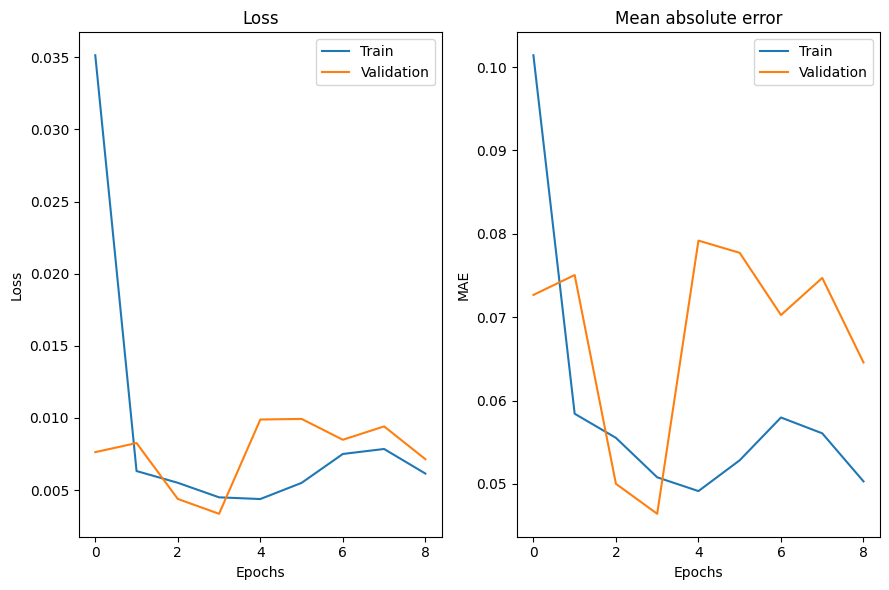

In [29]:
plot_history(ss_cnn_lstm_history)

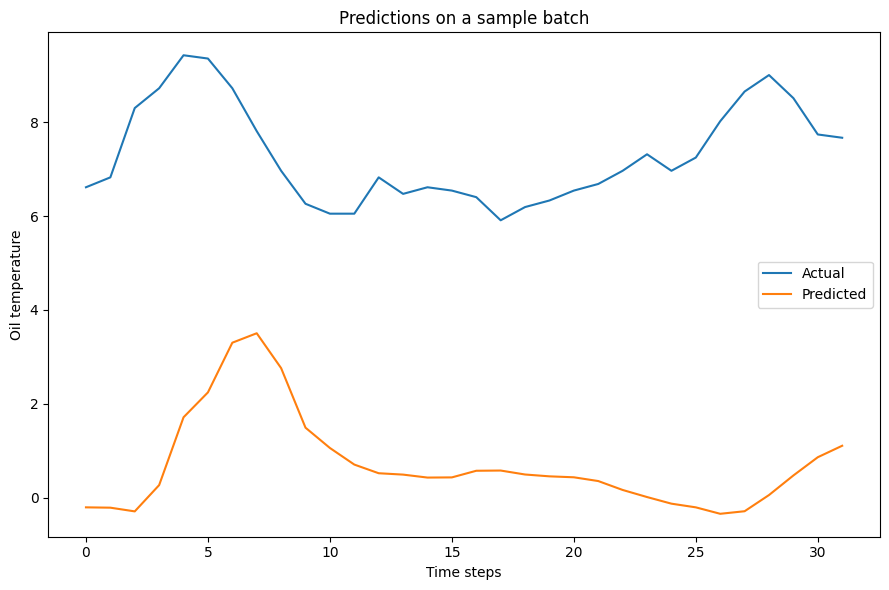

In [30]:
plot_predictions(ss_cnn_lstm, ss_sample_batch, 'single_step')

### Evaluation 

 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0335 - mean_absolute_error: 0.1636

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372 - mean_absolute_error: 0.1720
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0668 - mean_absolute_error: 0.2408


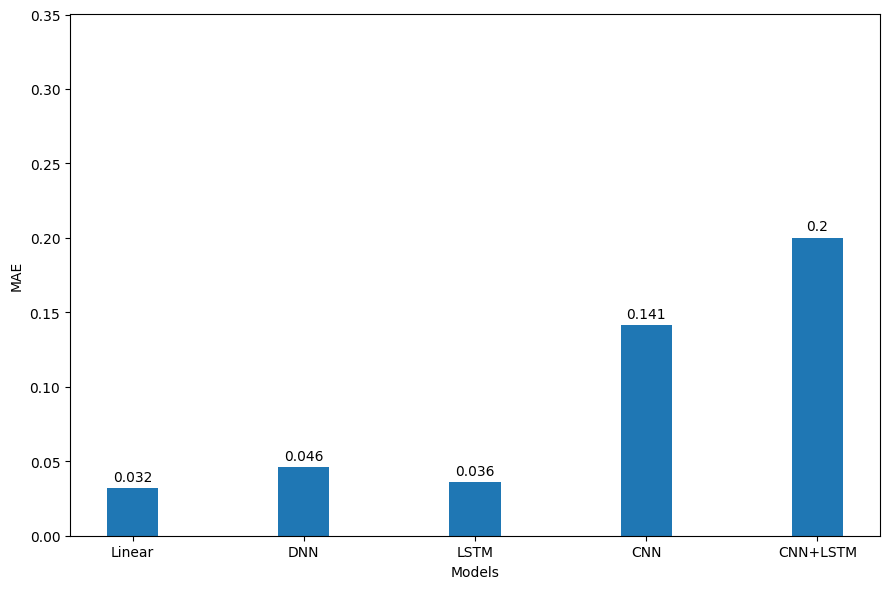

In [31]:
model_list = ['Linear', 'DNN', 'LSTM', 'CNN', 'CNN+LSTM']

ss_mae = [0.032, 0.046, 0.036]
ss_mae.append(ss_cnn.evaluate(test_ds_ss)[1])
ss_mae.append(ss_cnn_lstm.evaluate(test_ds_ss)[1])

plot_evaluation(model_list, ss_mae)

## Multi-step model 

In [32]:
# Create a multi-step window with a kernel length of 6
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 24
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH -1

train_ds_ms = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
val_ds_ms = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
test_ds_ms = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])


ms_sample_batch = next(iter(test_ds_ms))

In [33]:
# Create a CNN model
ms_cnn = Sequential([
    Conv1D(32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ms_cnn_history = train_model(ms_cnn, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0650 - val_loss: 0.0067 - val_mean_absolute_error: 0.0672
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0886 - val_loss: 0.0106 - val_mean_absolute_error: 0.0864
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0621 - val_loss: 0.0055 - val_mean_absolute_error: 0.0573
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0566 - val_loss: 0.0026 - val_mean_absolute_error: 0.0403
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0566 - val_loss: 0.0031 - val_mean_absolute_error: 0.0446
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0621 - val_loss: 0.0030 - val_mean_absolute_error: 0.0435
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0653 - v

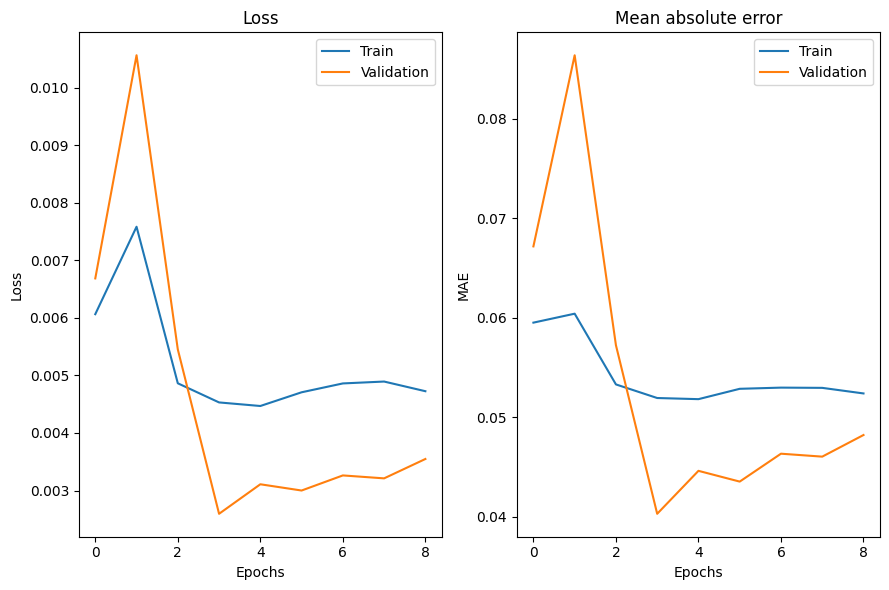

In [34]:
plot_history(ms_cnn_history)
# plot_predictions(ms_cnn, ms_sample_batch, 'multi_step')

### Combine CNN and LSTM 

In [35]:
# Combine CNN and LSTM
ms_cnn_lstm = Sequential([
    Conv1D(32, kernel_size=(KERNEL_LENGTH, ), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dense(8, activation='relu'),
    Dense(1)
])

ms_cnn_lstm_history = train_model(ms_cnn_lstm, train_ds_ms, val_ds_ms, use_scheduler=True)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0824 - mean_absolute_error: 0.1896 - val_loss: 0.0136 - val_mean_absolute_error: 0.1035 - learning_rate: 0.0010
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0261 - mean_absolute_error: 0.1142 - val_loss: 0.0130 - val_mean_absolute_error: 0.1008 - learning_rate: 0.0010
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0341 - mean_absolute_error: 0.1339 - val_loss: 0.0300 - val_mean_absolute_error: 0.1590 - learning_rate: 9.0484e-04
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0231 - mean_absolute_error: 0.1141 - val_loss: 0.0524 - val_mean_absolute_error: 0.2067 - learning_rate: 8.1873e-04
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0132 - mean_absolute_error: 0.0892 - val_loss: 0.0141 - val_mean_absolute_error: 0.0984 - learning_rate: 7.4082e-04
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0084 - mean_absolute_error: 0.0718 - val_loss: 0.0

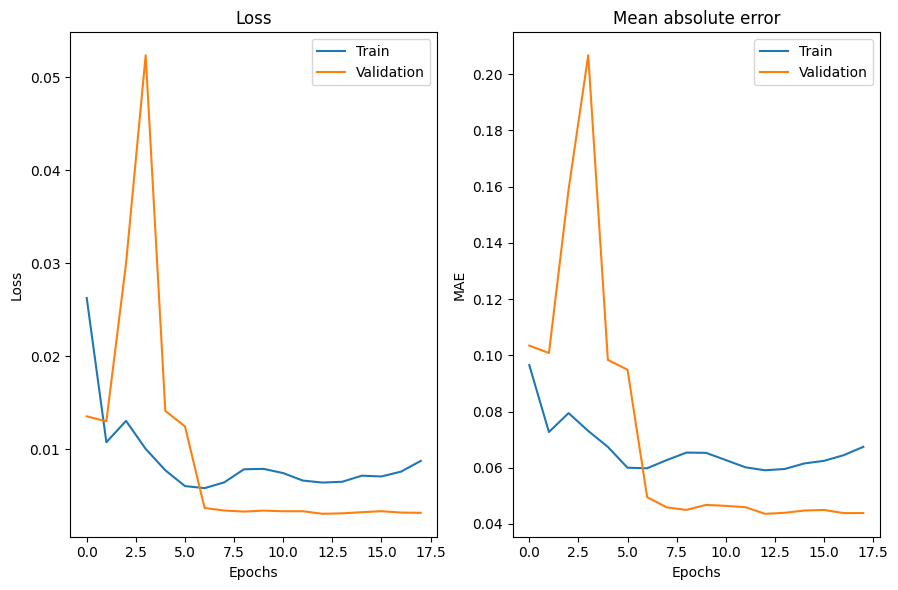

In [36]:
plot_history(ms_cnn_lstm_history)
# plot_predictions(ms_cnn_lstm, ms_sample_batch, 'multi_step')

### Evaluation 

 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0190 - mean_absolute_error: 0.1085

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - mean_absolute_error: 0.1769
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0797 - mean_absolute_error: 0.2425


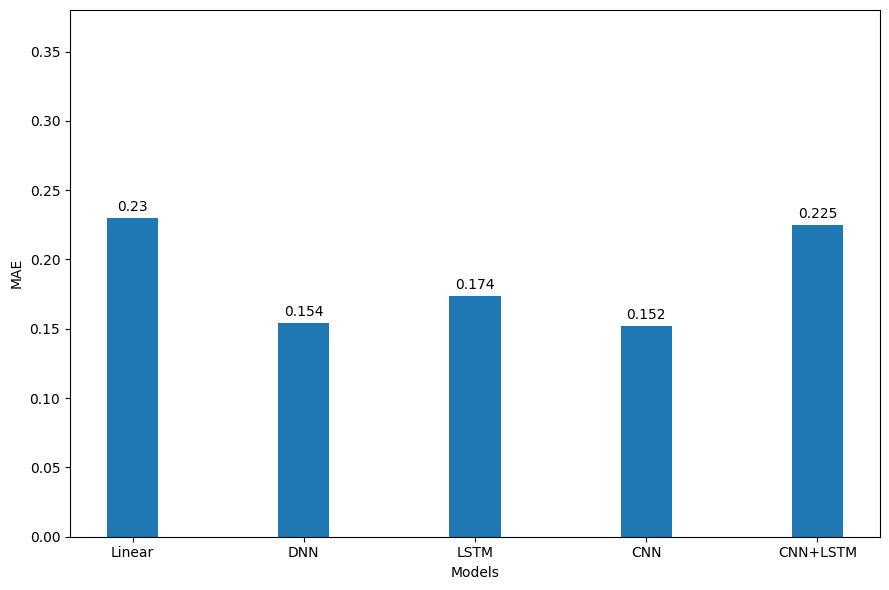

In [38]:
ms_mae = [0.23, 0.154, 0.174]
ms_mae.append(ms_cnn.evaluate(test_ds_ms)[1])
ms_mae.append(ms_cnn_lstm.evaluate(test_ds_ms)[1])

plot_evaluation(model_list, ms_mae)

## Multi-output 

In [39]:
# Create a multi-output window with a kernel length of 6
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 1
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH - 1

train_ds_mo = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [42]:
# CNN model
mo_cnn = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_LENGTH, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)
])

mo_cnn_history = train_model(mo_cnn, train_ds_mo, val_ds_mo)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0856 - val_loss: 0.0206 - val_mean_absolute_error: 0.1162
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0655 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0411 - val_mean_absolute_error: 0.1669
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0653 - val_loss: 0.0191 - val_mean_absolute_error: 0.1086
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0699 - val_loss: 0.0169 - val_mean_absolute_error: 0.1066
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0628 - val_loss: 0.0165 - val_mean_absolute_error: 0.1051
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0623 - v

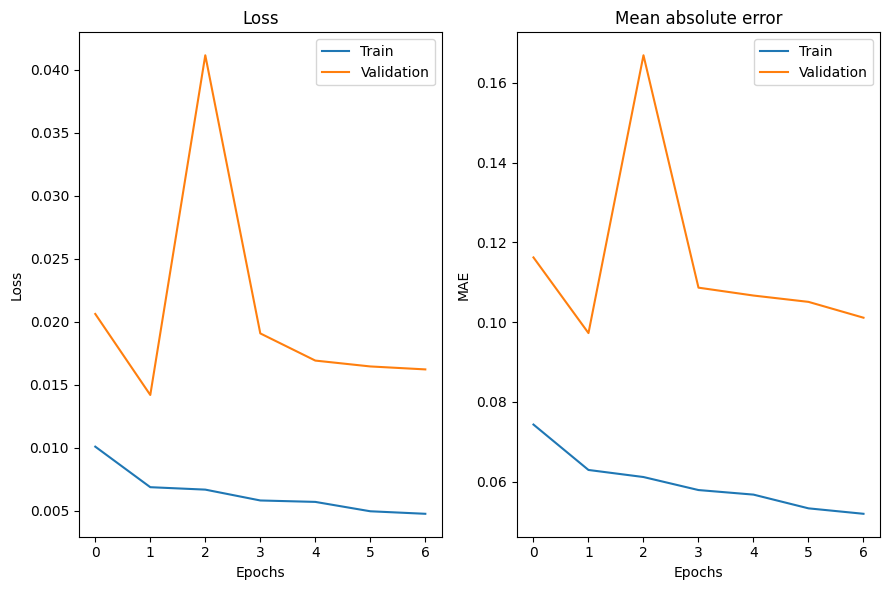

In [43]:
plot_history(mo_cnn_history)
# plot_predictions(mo_cnn, mo_sample_batch, 'multi_output')

### Combine CNN and LSTM 

In [44]:
# CNN + LSTM model
mo_cnn_lstm = Sequential([
    Conv1D(32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dense(2)

])

mo_cnn_lstm_history = train_model(mo_cnn_lstm, train_ds_mo, val_ds_mo, use_scheduler=True)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1046 - mean_absolute_error: 0.2202 - val_loss: 0.0139 - val_mean_absolute_error: 0.0945 - learning_rate: 0.0010
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - mean_absolute_error: 0.0926 - val_loss: 0.0148 - val_mean_absolute_error: 0.0994 - learning_rate: 0.0010
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - mean_absolute_error: 0.0922 - val_loss: 0.0177 - val_mean_absolute_error: 0.1134 - learning_rate: 9.0484e-04
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0783 - val_loss: 0.0196 - val_mean_absolute_error: 0.1056 - learning_rate: 8.1873e-04
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mean_absolute_error: 0.0659 - val_loss: 0.0227 - val_mean_absolute_error: 0.1144 - learning_rate: 7.4082e-04
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0662 - val_loss: 0.0144 - 

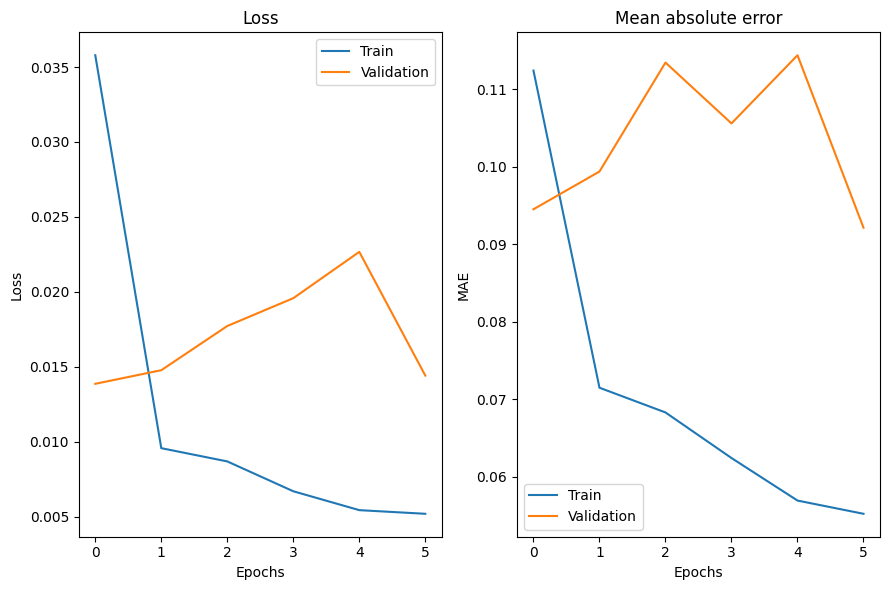

In [45]:
plot_history(mo_cnn_lstm_history)
# plot_predictions(mo_cnn_lstm, mo_sample_batch, 'multi_output')

### Evaluation 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0695 - mean_absolute_error: 0.2268
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0845 - mean_absolute_error: 0.2515


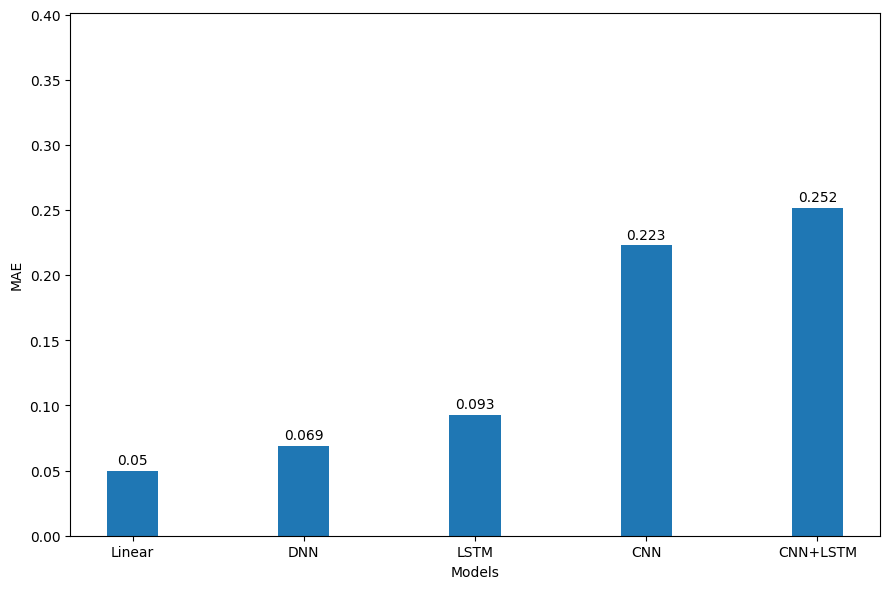

In [46]:
mo_mae = [0.05, 0.069, 0.093]

mo_mae.append(mo_cnn.evaluate(test_ds_mo)[1])
mo_mae.append(mo_cnn_lstm.evaluate(test_ds_mo)[1])

plot_evaluation(model_list, mo_mae)